**Import all relevant libraries**

In [523]:
# library to handle data in a vectorized manner
import numpy as np 

# library for data analsysis
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 

# convert an address into latitude and longitude values
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


**Import file containing geographical coordinates & details for Canada**

In [524]:
canada = pd.read_csv('/Users/vignesh/Desktop/projects/Final/CA Postal Code Data.csv')

In [525]:
canada.head()

,Postal Code,Neighborhood,Province,Province_Code,Admin Area 1,Admin Area 2,Admin Area 3,Admin Area 4,Latitude,Longitude,Accuracy
0,T0A,Eastern Alberta (St. Paul),Alberta,AB,NaN,NaN,NaN,NaN,54.7660,-111.7174,6.0
1,T0B,Wainwright Region (Tofield),Alberta,AB,NaN,NaN,NaN,NaN,53.0727,-111.5816,6.0
2,T0C,Central Alberta (Stettler),Alberta,AB,NaN,NaN,NaN,NaN,52.1431,-111.6941,5.0
3,T0E,Western Alberta (Jasper),Alberta,AB,NaN,NaN,NaN,NaN,53.6758,-115.0948,5.0
4,T0G,North Central Alberta (Slave Lake),Alberta,AB,NaN,NaN,NaN,NaN,55.6993,-114.4529,6.0


In [526]:
canada.shape

(1653, 11)

**Slicing the data down to only Vancouver**

In [527]:
vancouver = canada.drop(canada.loc[canada['Admin Area 1']!="Vancouver"].index)

In [528]:
vancouver.head()

,Postal Code,Neighborhood,Province,Province_Code,Admin Area 1,Admin Area 2,Admin Area 3,Admin Area 4,Latitude,Longitude,Accuracy
154,V5K,Vancouver (North Hastings-Sunrise),British Columbia,BC,Vancouver,5965814.0,NaN,NaN,49.2807,-123.0397,6.0
155,V5L,Vancouver (North Grandview-Woodlands),British Columbia,BC,Vancouver,5965814.0,NaN,NaN,49.2795,-123.0667,6.0
156,V5M,Vancouver (South Hastings-Sunrise / North Renf...,British Columbia,BC,Vancouver,5965814.0,NaN,NaN,49.2600,-123.0398,6.0
157,V5N,Vancouver (South Grandview-Woodlands / NE Kens...,British Columbia,BC,Vancouver,5965814.0,NaN,NaN,49.2551,-123.0667,6.0
158,V5P,Vancouver (SE Kensington / Victoria-Fraserview),British Columbia,BC,Vancouver,5965814.0,NaN,NaN,49.2220,-123.0683,6.0


In [529]:
vancouver.shape

(44, 11)

**Data Cleanup**

In [530]:
#Drop redundant columns and reset index
vancouver.drop(['Accuracy', 'Province', 'Province_Code', 'Admin Area 1', 'Admin Area 2', 'Admin Area 3', 'Admin Area 4'],axis = 1, inplace = True)
vancouver.reset_index(drop=True, inplace=True)

In [531]:
#Clean up values in Neighborhood column
i = 0
temp_list = []
for index, row in vancouver.iterrows():
    temp_list.append(vancouver['Neighborhood'][i].replace('Vancouver (','',True))
    i+=1  
vancouver['Neighborhood'] = temp_list
i = 0
temp_list1 = []
for index, row in vancouver.iterrows():
    temp_list1.append(vancouver['Neighborhood'][i].replace(')','',True))
    i+=1
vancouver['Neighborhood'] = temp_list1

In [532]:
vancouver.head()

,Postal Code,Neighborhood,Latitude,Longitude
0,V5K,North Hastings-Sunrise,49.2807,-123.0397
1,V5L,North Grandview-Woodlands,49.2795,-123.0667
2,V5M,South Hastings-Sunrise / North Renfrew-Colling...,49.2600,-123.0398
3,V5N,South Grandview-Woodlands / NE Kensington,49.2551,-123.0667
4,V5P,SE Kensington / Victoria-Fraserview,49.2220,-123.0683


In [533]:
vancouver.shape

(44, 4)

**Mapping Vancouver**

In [534]:
#define user agent for geocoding
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="va_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Vancouver are 49.2608724, -123.1139529.


In [535]:
# create map of Vancouver using latitude and longitude values
map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(vancouver['Latitude'], vancouver['Longitude'], vancouver['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

**Foursquare Credentials**

In [536]:
CLIENT_ID = 'DQICPBYKZAPDYAZQOMNZVZO5TOT2RBI4SZB1FDO0NCBIF2YW'
CLIENT_SECRET = 'FC0SOPVKEHOM0UD34YLIMEGD3PSYTPH0LPIJKQXT45LO1SCD'
VERSION = '20192105'

**Explore Neighborhoods**

In [537]:
# function to explore all neighborhoods
LIMIT = 200
radius = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
         # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [538]:
vancouver_venues = getNearbyVenues(names=vancouver['Neighborhood'],
                                   latitudes=vancouver['Latitude'],
                                   longitudes=vancouver['Longitude']
                                  )

North Hastings-Sunrise
North Grandview-Woodlands
South Hastings-Sunrise / North Renfrew-Collingwood
South Grandview-Woodlands / NE Kensington
SE Kensington / Victoria-Fraserview
South Renfrew-Collingwood
Killarney
East Mount Pleasant
West Kensington / NE Riley Park-Little Mountain
SE Riley Park-Little Mountain / SW Kensington / NE Oakridge / North Sunset
SE Oakridge / East Marpole / South Sunset
West Mount Pleasant / West Riley Park-Little Mountain
East Fairview / South Cambie
Strathcona / Chinatown / Downtown Eastside
NE Downtown / Harbour Centre / Gastown / Yaletown
Waterfront / Coal Harbour / Canada Place
South West End
North West End / Stanley Park
West Fairview / Granville Island / NE Shaughnessy
NW Shaughnessy / East Kitsilano / Quilchena
Central Kitsilano
NW Arbutus Ridge
South Shaughnessy / NW Oakridge / NE Kerrisdale / SE Arbutus Ridge
Dunbar-Southlands / Musqueam
SE Kerrisdale / SW Oakridge / West Marpole
West Kitsilano / Jericho
Chaldecutt / South University Endowment Lands


In [539]:
vancouver_venues.shape

(854, 7)

In [540]:
print('There are {} unique categories.'.format(len(vancouver_venues['Venue Category'].unique())))

There are 188 unique categories.


In [541]:
master_list = vancouver_venues['Venue Category'].unique()

In [542]:
master_list

array(['Fair', 'Theme Park Ride / Attraction', 'Farm', 'Theme Park',
       'Event Space', 'Bakery', 'Beer Garden', 'Soccer Field', 'Stadium',
       'Sandwich Place', 'Vietnamese Restaurant', 'Park', 'Inn',
       'Bus Station', 'Asian Restaurant', 'Sushi Restaurant',
       'Pizza Place', 'Deli / Bodega', 'Coffee Shop', 'Theater',
       'Brewery', 'Fried Chicken Joint', 'Italian Restaurant',
       'Thai Restaurant', 'Breakfast Spot', 'Café', 'Japanese Restaurant',
       'Thrift / Vintage Store', 'Chinese Restaurant',
       'Electronics Store', 'Indian Restaurant', 'Caribbean Restaurant',
       'Convenience Store', 'Fish & Chips Shop', 'Bus Stop',
       'Grocery Store', 'Bar', 'Office', 'Pet Store', 'Liquor Store',
       'Paper / Office Supplies Store', 'Mexican Restaurant',
       'Furniture / Home Store', 'Metro Station', 'Storage Facility',
       'Gym', 'Farmers Market', 'Gym / Fitness Center', 'Concert Hall',
       'Music Venue', 'Arts & Crafts Store', 'Bookstore', 'Skati

**Create Custom Focus Areas**

In [543]:
shopping_list = []
food_and_beverage_list = []
entertainment_list = []
healthyliving_list = []
services_list = []

In [544]:
shopping_list = ['Thrift / Vintage Store', 'Electronics Store', 'Convenience Store', 'Market', 'Liquor Store', 
                 'Pet Store', 'Grocery Store', 'Paper / Office Supplies Store', 'Department Store', 
                 'Furniture / Home Store', 'Shop & Service', 'Hobby Shop', 'Farmers Market', 'Arts & Crafts Store', 
                 'Bookstore', 'Motorcycle Shop', 'Pharmacy','Shopping Mall', 'Automotive Shop', 'Supermarket', 
                 'Sporting Goods Shop', 'Miscellaneous Shop','Warehouse Store', 'Clothing Store', 'Discount Store',
                 'Cosmetics Shop', 'Jewelry Store', 'Leather Goods Store', "Men's Store", 'Mobile Phone Shop',
                 "Women's Store", 'Toy / Game Store', 'Video Store', 'Butcher', 'Gift Shop', 'Lingerie Store', 'Shoe Store', 
                 'Optical Shop', 'Health Food Store'] 
food_and_beverage_list = ['Bakery', 'Beer Garden', 'Sandwich Place', 'Vietnamese Restaurant', 'Inn', 'Sushi Restaurant', 
                          'Pizza Place', 'Deli / Bodega', 'Coffee Shop', 'Brewery', 'Fried Chicken Joint', 
                          'Italian Restaurant', 'Thai Restaurant', 'Breakfast Spot', 'Café', 'Japanese Restaurant',
                          'Chinese Restaurant', 'Asian Restaurant', 'Indian Restaurant', 'Caribbean Restaurant', 
                          'Fish & Chips Shop', 'Bar', 'Liquor Store', 'Mexican Restaurant', 'Noodle House', 
                          'Middle Eastern Restaurant', 'Hotel', 'Fast Food Restaurant', 'Juice Bar', 
                          'Ethiopian Restaurant', 'Pub', 'Sports Bar', 'Ice Cream Shop', 'Filipino Restaurant', 
                          'Greek Restaurant', 'Tea Room', 'Dessert Shop', 'Diner', 'Restaurant', 'Malay Restaurant',
                          'Cafeteria', 'Pie Shop', 'Seafood Restaurant', 'Cheese Shop', 'Burger Joint', 
                          'Belgian Restaurant', 'Ramen Restaurant', 'Hot Dog Joint', 'Salad Place', 'Steakhouse', 
                          'Lounge', 'Taco Place', 'Lebanese Restaurant', 'Japanese Curry Restaurant', 
                          'BBQ Joint', 'Hawaiian Restaurant','Wine Bar', 'American Restaurant', 'Wine Shop',
                          'Food Court', 'Mediterranean Restaurant', 'Food Truck', 'Hotel Bar', 'Gastropub',
                          'Australian Restaurant', 'Donut Shop', 'Poke Place', 'Chocolate Shop', 'Cocktail Bar', 
                          'Irish Pub', 'New American Restaurant', 'French Restaurant', 'Gay Bar', 
                          'South Indian Restaurant','Falafel Restaurant','Frozen Yogurt Shop', 
                          'Comfort Food Restaurant', 'Bubble Tea Shop', 'Food & Drink Shop', 
                          'Vegetarian / Vegan Restaurant', 'Gourmet Shop', 'Hotpot Restaurant', 'Dim Sum Restaurant',
                          'Bagel Shop', 'Portuguese Restaurant','Tapas Restaurant']
entertainment_list = ['Fair', 'Theme Park Ride / Attraction', 'Farm', 'Theme Park', 'Event Space', 
                      'Theater', 'Concert Hall', 'Music Venue','Outdoor Sculpture', 'Museum', 'Plaza',
                      'Scenic Lookout', 'Art Gallery', 'Movie Theater', 'Nightclub', 'Comedy Club',
                      'Garden', 'Historic Site', 'Science Museum','Indie Movie Theater', 'Harbor / Marina',
                      'Mountain', 'Resort', 'Ski Chalet', 'Dance Studio', 'Performing Arts Venue']
healthyliving_list = ['Park', 'Gym', 'Gym / Fitness Center', 
                      'Skating Rink', 'Lake', 'Beach', 'Field', 'Sporting Goods Shop', 
                      'Soccer Stadium', 'Spa', 'Hockey Arena', 'Athletics & Sports', 'Yoga Studio',
                      'Trail', 'Tennis Court','Baseball Field', 'Ski Trail', 'Ski Chairlift', 'Track', 'Health Food Store']
services_list = ['Bus Station', 'Bus Line', 'Office', 'Metro Station', 'Bus Stop', 'Storage Facility', 
                 'Child Care Service', 'Church', 'Dog Run', 'Bank', 'Light Rail Station', 
                 'Trade School', 'Building', 'Financial or Legal Service','Train Station',
                 'Home Service','Boat or Ferry', 'Airport Terminal']

In [545]:
print("Master List =",len(master_list))
print("Shopping List =",len(shopping_list))
print("Food & Beverage List =",len(food_and_beverage_list))
print("Entertainment List =",len(entertainment_list))
print("Healthy Living List =",len(healthyliving_list))
print("Services List =",len(services_list))

Master List = 188
Shopping List = 39
Food & Beverage List = 86
Entertainment List = 26
Healthy Living List = 20
Services List = 18


In [546]:
vancouver_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Hastings-Sunrise,49.2807,-123.0397,The Fair at the PNE,49.282971,-123.042109,Fair
1,North Hastings-Sunrise,49.2807,-123.0397,Wooden Roller Coaster,49.281744,-123.035128,Theme Park Ride / Attraction
2,North Hastings-Sunrise,49.2807,-123.0397,Livestock Barns,49.284037,-123.039278,Farm
3,North Hastings-Sunrise,49.2807,-123.0397,Playland,49.281924,-123.036258,Theme Park
4,North Hastings-Sunrise,49.2807,-123.0397,Hastings Community Centre,49.280778,-123.039176,Event Space


In [547]:
van_shopping = vancouver_venues[vancouver_venues['Venue Category'].isin(shopping_list)]
van_fandb = vancouver_venues[vancouver_venues['Venue Category'].isin(food_and_beverage_list)]
van_ent = vancouver_venues[vancouver_venues['Venue Category'].isin(entertainment_list)]
van_health = vancouver_venues[vancouver_venues['Venue Category'].isin(healthyliving_list)]
van_services = vancouver_venues[vancouver_venues['Venue Category'].isin(services_list)]

**Exploratory Data Analysis**

In [548]:
van_exp_all = vancouver_venues.groupby('Neighborhood')['Venue'].nunique()
van_exp_fandb = van_fandb.groupby('Neighborhood')['Venue'].nunique()
van_exp_shop = van_shopping.groupby('Neighborhood')['Venue'].nunique()
van_exp_ent = van_ent.groupby('Neighborhood')['Venue'].nunique()
van_exp_health = van_health.groupby('Neighborhood')['Venue'].nunique()
van_exp_services = van_services.groupby('Neighborhood')['Venue'].nunique()

In [549]:
van_exp_all = van_exp_all.sort_values(ascending = False)
van_exp_fandb = van_exp_fandb.sort_values(ascending = False)
van_exp_shop = van_exp_shop.sort_values(ascending = False)
van_exp_ent = van_exp_ent.sort_values(ascending = False)
van_exp_health = van_exp_health.sort_values(ascending = False)
van_exp_services = van_exp_services.sort_values(ascending = False)

In [550]:
van_exp_all.shape

(40,)

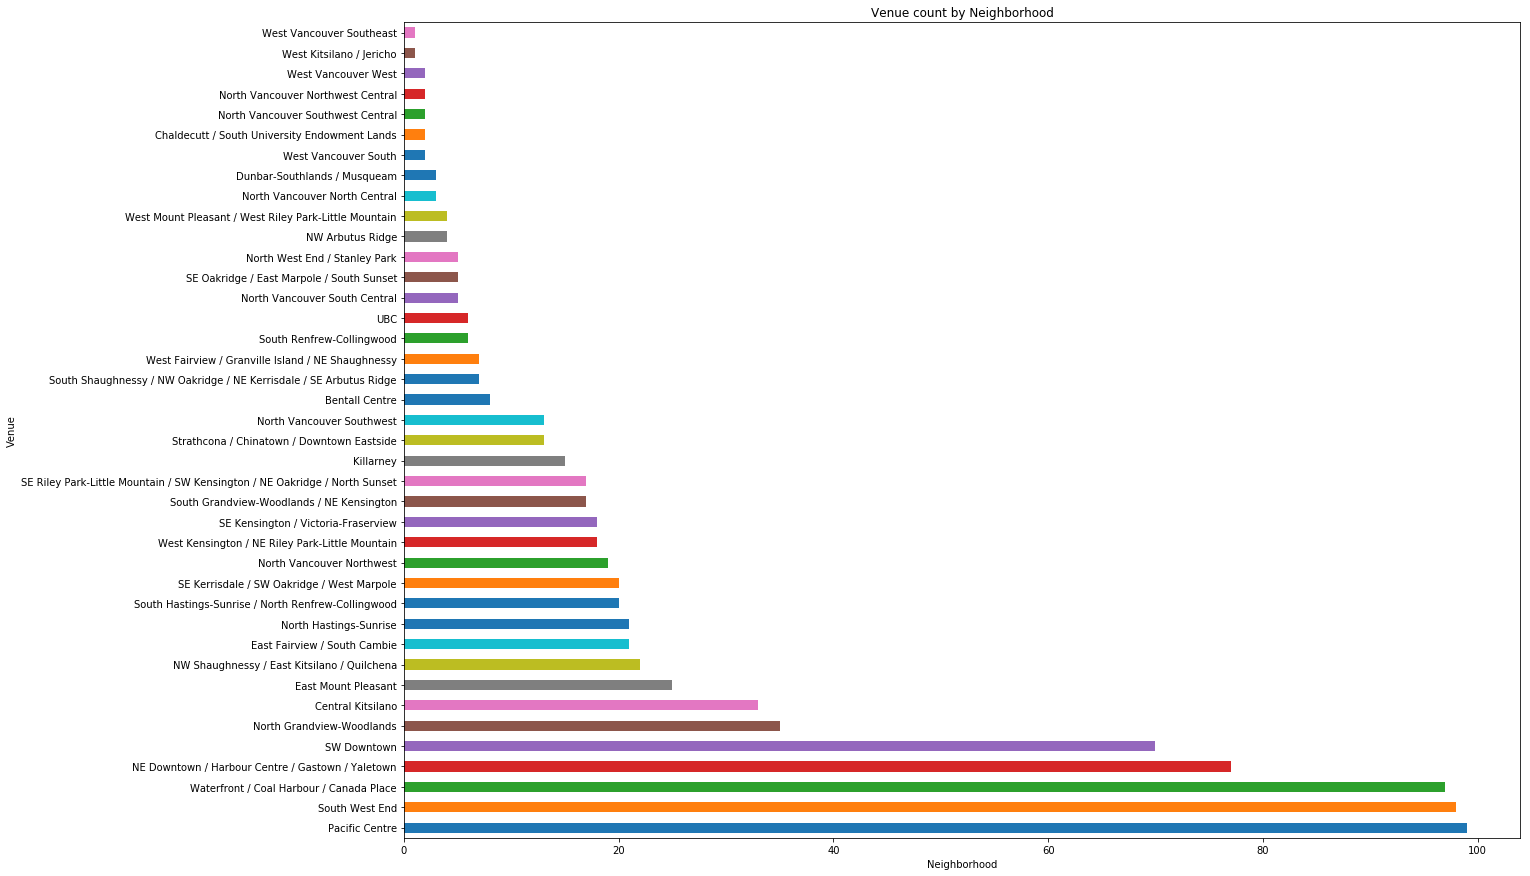

In [551]:
van_exp_all.plot(kind='barh', figsize=(20, 15))
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Venue') # add y-label to the plot
plt.title('Venue count by Neighborhood') # add title to the plot
plt.show()

In [552]:
van_exp_fandb.sum()

560

In [553]:
van_exp_shop.sum()

117

In [554]:
van_exp_ent.sum()

61

In [555]:
van_exp_health.sum()

72

In [556]:
van_exp_services.sum()

36

**Analyze each neighborhood by Focus areas**

In [557]:
# one hot encoding
van_fandb_onehot = pd.get_dummies(van_fandb[['Venue Category']], prefix="", prefix_sep="")
van_shopping_onehot = pd.get_dummies(van_shopping[['Venue Category']], prefix="", prefix_sep="")
van_ent_onehot = pd.get_dummies(van_ent[['Venue Category']], prefix="", prefix_sep="")
van_health_onehot = pd.get_dummies(van_health[['Venue Category']], prefix="", prefix_sep="")
van_services_onehot = pd.get_dummies(van_services[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
van_fandb_onehot['Neighborhood'] = van_fandb['Neighborhood'] 
van_shopping_onehot['Neighborhood'] = van_shopping['Neighborhood'] 
van_ent_onehot['Neighborhood'] = van_ent['Neighborhood'] 
van_health_onehot['Neighborhood'] = van_health['Neighborhood'] 
van_services_onehot['Neighborhood'] = van_services['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1 = [van_fandb_onehot.columns[-1]] + list(van_fandb_onehot.columns[:-1])
fixed_columns2 = [van_shopping_onehot.columns[-1]] + list(van_shopping_onehot.columns[:-1])
fixed_columns3 = [van_ent_onehot.columns[-1]] + list(van_ent_onehot.columns[:-1])
fixed_columns4 = [van_health_onehot.columns[-1]] + list(van_health_onehot.columns[:-1])
fixed_columns5 = [van_services_onehot.columns[-1]] + list(van_services_onehot.columns[:-1])

van_fandb_onehot = van_fandb_onehot[fixed_columns1]
van_shopping_onehot = van_shopping_onehot[fixed_columns2]
van_ent_onehot = van_ent_onehot[fixed_columns3]
van_health_onehot = van_health_onehot[fixed_columns4]
van_services_onehot = van_services_onehot[fixed_columns5]

# reset index after grouping by neighborhood
van_fandb_grouped = van_fandb_onehot.groupby('Neighborhood').mean().reset_index()
van_shopping_grouped = van_shopping_onehot.groupby('Neighborhood').mean().reset_index()
van_ent_grouped = van_ent_onehot.groupby('Neighborhood').mean().reset_index()
van_health_grouped = van_health_onehot.groupby('Neighborhood').mean().reset_index()
van_services_grouped = van_services_onehot.groupby('Neighborhood').mean().reset_index()

In [558]:
van_health_grouped.head()

,Neighborhood,Athletics & Sports,Beach,Field,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Lake,Park,Skating Rink,Ski Chairlift,Ski Trail,Soccer Stadium,Spa,Sporting Goods Shop,Tennis Court,Track,Trail,Yoga Studio
0,Bentall Centre,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,Central Kitsilano,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.5
2,Chaldecutt / South University Endowment Lands,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,East Fairview / South Cambie,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,East Mount Pleasant,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [559]:
# define function to return most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [560]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
van_fandb_venues_sorted = pd.DataFrame(columns=columns)
van_shopping_venues_sorted = pd.DataFrame(columns=columns)
van_ent_venues_sorted = pd.DataFrame(columns=columns)
van_health_venues_sorted = pd.DataFrame(columns=columns)
van_services_venues_sorted = pd.DataFrame(columns=columns)

van_fandb_venues_sorted['Neighborhood'] = van_fandb_grouped['Neighborhood']
van_shopping_venues_sorted['Neighborhood'] = van_shopping_grouped['Neighborhood']
van_ent_venues_sorted['Neighborhood'] = van_ent_grouped['Neighborhood']
van_health_venues_sorted['Neighborhood'] = van_health_grouped['Neighborhood']
van_services_venues_sorted['Neighborhood'] = van_services_grouped['Neighborhood']

for ind in np.arange(van_fandb_grouped.shape[0]):
    van_fandb_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_fandb_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(van_shopping_grouped.shape[0]):
    van_shopping_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_shopping_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(van_ent_grouped.shape[0]):
    van_ent_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_ent_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(van_health_grouped.shape[0]):
    van_health_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_health_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(van_services_grouped.shape[0]):
    van_services_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_services_grouped.iloc[ind, :], num_top_venues)

In [561]:
van_fandb_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bentall Centre,American Restaurant,Gastropub,Irish Pub,Breakfast Spot,Filipino Restaurant
1,Central Kitsilano,Coffee Shop,Pub,Pizza Place,Café,Wine Shop
2,Dunbar-Southlands / Musqueam,Vietnamese Restaurant,Fast Food Restaurant,Wine Shop,Filipino Restaurant,Deli / Bodega
3,East Fairview / South Cambie,Coffee Shop,Sushi Restaurant,Malay Restaurant,Vietnamese Restaurant,Liquor Store
4,East Mount Pleasant,Sushi Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Sandwich Place,Sports Bar


**Cluster neighborhoods according to Focus Areas**

In [562]:
# set number of clusters
kclusters = 5

van_fandb_grouped_clustering = van_fandb_grouped.drop('Neighborhood', 1)
van_shopping_grouped_clustering = van_shopping_grouped.drop('Neighborhood', 1)
van_ent_grouped_clustering = van_ent_grouped.drop('Neighborhood', 1)
van_health_grouped_clustering = van_health_grouped.drop('Neighborhood', 1)
van_services_grouped_clustering = van_services_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters, random_state=0).fit(van_fandb_grouped_clustering)
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(van_shopping_grouped_clustering)
kmeans3 = KMeans(n_clusters=kclusters, random_state=0).fit(van_ent_grouped_clustering)
kmeans4 = KMeans(n_clusters=kclusters, random_state=0).fit(van_health_grouped_clustering)
kmeans5 = KMeans(n_clusters=kclusters, random_state=0).fit(van_services_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans1.labels_[0:])
print(kmeans2.labels_[0:])
print(kmeans3.labels_[0:])
print(kmeans4.labels_[0:])
print(kmeans5.labels_[0:])

[1 1 1 2 1 0 1 1 1 1 1 2 1 2 1 1 0 4 0 1 1 2 1 0 1 1 2 1 1 2 0 3]
[0 0 0 0 0 0 0 2 1 0 0 0 4 2 3 0 0 0 0 0 0 0]
[1 1 0 4 0 0 0 3 1 0 0 0 0 2 1 0 0]
[4 2 0 0 0 2 2 0 1 1 1 4 0 1 2 0 2 3 2 2 0 2 0 2 0 1]
[0 3 1 1 4 1 2 2 2 1 1 0 0 1 1 1 2 0 3]


In [563]:
van_fandb_grouped_clustering.head()

,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Belgian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Cafeteria,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Inn,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,Pie Shop,Pizza Place,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0.25,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.00,0.0,0.0,0.0,0.038462,0.0,0.0000,0.0,0.0,0.038462,0.0,0.000000,0.0,0.000000,0.076923,0.0,0.0,0.000000,0.0,0.0,0.115385,0.0,0.038462,0.038462,0.0,0.038462,0.0,0.000,0.0,0.038462,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.038462,0.0,0.00,0.038462,0.0,0.038462,0.000000,0.0,0.038462,0.0,0.000000,0.0,0.038462,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.076923,0.0,0.038462,0.0,0.0000,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0,0.038462
2,0.00,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.000000
3,0.00,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.071429,0.0,0.071429,0.071429,0.0,0.0,0.071429,0.0,0.0,0.214286,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.071429,0.0,0.071429,0.0,0.071429,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.071429,0.0,0.000000
4,0.00,0.0,0.0,0.0,0.000000,0.0,0.0625,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.125,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.062500,0.000000,0.0,0.062500,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0625,0.0,0.0,0.0625,0.0,0.187500,0.0,0.0,0.0,0.0,0.000000,0.125000,0.0,0.000000


In [564]:
# add clustering labels
van_fandb_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)
van_shopping_venues_sorted.insert(0, 'Cluster Labels', kmeans2.labels_)
van_ent_venues_sorted.insert(0, 'Cluster Labels', kmeans3.labels_)
van_health_venues_sorted.insert(0, 'Cluster Labels', kmeans4.labels_)
van_services_venues_sorted.insert(0, 'Cluster Labels', kmeans5.labels_)

van_fandb_merged = vancouver
van_shopping_merged = vancouver
van_ent_merged = vancouver
van_health_merged = vancouver
van_services_merged = vancouver

# merge data to add latitude/longitude for each neighborhood
van_fandb_merged = van_fandb_merged.join(van_fandb_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
van_shopping_merged = van_shopping_merged.join(van_shopping_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
van_ent_merged = van_ent_merged.join(van_ent_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
van_health_merged = van_health_merged.join(van_health_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
van_services_merged = van_services_merged.join(van_services_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [565]:
# clean up dataframe and reindex for each neighborhood
van_fandb_merged.dropna(inplace = True)
van_shopping_merged.dropna(inplace = True)
van_ent_merged.dropna(inplace = True)
van_health_merged.dropna(inplace = True)
van_services_merged.dropna(inplace = True)

van_fandb_merged.reset_index(drop=True, inplace=True)
van_shopping_merged.reset_index(drop=True, inplace=True)
van_ent_merged.reset_index(drop=True, inplace=True)
van_health_merged.reset_index(drop=True, inplace=True)
van_services_merged.reset_index(drop=True, inplace=True)

van_fandb_merged = van_fandb_merged.astype({'Cluster Labels' : int})
van_shopping_merged = van_shopping_merged.astype({'Cluster Labels' : int})
van_ent_merged = van_ent_merged.astype({'Cluster Labels' : int})
van_health_merged = van_health_merged.astype({'Cluster Labels' : int})
van_services_merged = van_services_merged.astype({'Cluster Labels' : int})

In [566]:
# create map
map_clusters_fandb = folium.Map(location=[latitude, longitude], zoom_start=11)
map_clusters_shopping = folium.Map(location=[latitude, longitude], zoom_start=11)
map_clusters_ent = folium.Map(location=[latitude, longitude], zoom_start=11)
map_clusters_health = folium.Map(location=[latitude, longitude], zoom_start=11)
map_clusters_services = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors1 = []
for lat, lon, poi, cluster in zip(van_fandb_merged['Latitude'], van_fandb_merged['Longitude'], van_fandb_merged['Neighborhood'], van_fandb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_fandb)

markers_colors2= []
for lat, lon, poi, cluster in zip(van_shopping_merged['Latitude'], van_shopping_merged['Longitude'], van_shopping_merged['Neighborhood'], van_shopping_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_shopping)

markers_colors3= []
for lat, lon, poi, cluster in zip(van_ent_merged['Latitude'], van_ent_merged['Longitude'], van_ent_merged['Neighborhood'], van_ent_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_ent)

markers_colors4 = []
for lat, lon, poi, cluster in zip(van_health_merged['Latitude'], van_health_merged['Longitude'], van_health_merged['Neighborhood'], van_health_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_health)

markers_colors5 = []
for lat, lon, poi, cluster in zip(van_services_merged['Latitude'], van_services_merged['Longitude'], van_services_merged['Neighborhood'], van_services_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_services) 

**Food & Beverage Focus Area**

In [567]:
map_clusters_fandb

In [568]:
van_fandb_merged.loc[van_fandb_merged['Cluster Labels'] == 0, van_fandb_merged.columns[[1] + list(range(5, van_fandb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Killarney,Coffee Shop,Chinese Restaurant,Bakery,Liquor Store,Sushi Restaurant
9,SE Riley Park-Little Mountain / SW Kensington ...,Chinese Restaurant,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Asian Restaurant
11,West Mount Pleasant / West Riley Park-Little M...,Chinese Restaurant,Dessert Shop,Sushi Restaurant,Wine Shop,Filipino Restaurant
21,South Shaughnessy / NW Oakridge / NE Kerrisdal...,Chinese Restaurant,Coffee Shop,Asian Restaurant,Sushi Restaurant,Filipino Restaurant
23,SE Kerrisdale / SW Oakridge / West Marpole,Chinese Restaurant,Dessert Shop,Sushi Restaurant,Sandwich Place,Indian Restaurant


In [569]:
van_fandb_merged.loc[van_fandb_merged['Cluster Labels'] == 1, van_fandb_merged.columns[[1] + list(range(5, van_fandb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North Hastings-Sunrise,Sandwich Place,Vietnamese Restaurant,Asian Restaurant,Bakery,Sushi Restaurant
1,North Grandview-Woodlands,Café,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Deli / Bodega
3,South Grandview-Woodlands / NE Kensington,Café,Bakery,Wine Shop,Fish & Chips Shop,Dim Sum Restaurant
4,SE Kensington / Victoria-Fraserview,Pizza Place,Vietnamese Restaurant,Fried Chicken Joint,Middle Eastern Restaurant,Noodle House
5,South Renfrew-Collingwood,Fish & Chips Shop,Asian Restaurant,Hotel,Bar,Wine Shop
7,East Mount Pleasant,Sushi Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Sandwich Place,Sports Bar
13,Strathcona / Chinatown / Downtown Eastside,Cheese Shop,Seafood Restaurant,Deli / Bodega,Pie Shop,Café
14,NE Downtown / Harbour Centre / Gastown / Yaletown,Hotel,Restaurant,Coffee Shop,Italian Restaurant,Breakfast Spot
15,Waterfront / Coal Harbour / Canada Place,Hotel,Coffee Shop,American Restaurant,Café,Seafood Restaurant
16,South West End,Japanese Restaurant,Coffee Shop,Hotel,Restaurant,Bakery


In [570]:
van_fandb_merged.loc[van_fandb_merged['Cluster Labels'] == 2, van_fandb_merged.columns[[1] + list(range(5, van_fandb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,South Hastings-Sunrise / North Renfrew-Colling...,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Liquor Store
8,West Kensington / NE Riley Park-Little Mountain,Coffee Shop,Gourmet Shop,Ice Cream Shop,Liquor Store,Pizza Place
12,East Fairview / South Cambie,Coffee Shop,Sushi Restaurant,Malay Restaurant,Vietnamese Restaurant,Liquor Store
24,UBC,Coffee Shop,Fast Food Restaurant,Fish & Chips Shop,Dessert Shop,Dim Sum Restaurant
27,North Vancouver Southwest,Coffee Shop,Greek Restaurant,Burger Joint,Diner,Liquor Store
28,North Vancouver Northwest,Restaurant,Coffee Shop,Fast Food Restaurant,Wine Shop,Deli / Bodega


In [571]:
van_fandb_merged.loc[van_fandb_merged['Cluster Labels'] == 3, van_fandb_merged.columns[[1] + list(range(5, van_fandb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,West Vancouver West,Tapas Restaurant,Wine Shop,Filipino Restaurant,Deli / Bodega,Dessert Shop


In [572]:
van_fandb_merged.loc[van_fandb_merged['Cluster Labels'] == 4, van_fandb_merged.columns[[1] + list(range(5, van_fandb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,SE Oakridge / East Marpole / South Sunset,Indian Restaurant,Restaurant,Wine Shop,Filipino Restaurant,Dessert Shop


In [573]:
map_clusters_shopping

In [574]:
van_shopping_merged.loc[van_shopping_merged['Cluster Labels'] == 0, van_shopping_merged.columns[[1] + list(range(5, van_shopping_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North Grandview-Woodlands,Electronics Store,Thrift / Vintage Store,Grocery Store,Convenience Store,Women's Store
1,South Hastings-Sunrise / North Renfrew-Colling...,Furniture / Home Store,Liquor Store,Pet Store,Grocery Store,Paper / Office Supplies Store
2,South Grandview-Woodlands / NE Kensington,Arts & Crafts Store,Bookstore,Farmers Market,Electronics Store,Jewelry Store
3,SE Kensington / Victoria-Fraserview,Liquor Store,Convenience Store,Motorcycle Shop,Pet Store,Pharmacy
4,Killarney,Liquor Store,Shopping Mall,Grocery Store,Farmers Market,Pharmacy
5,East Mount Pleasant,Grocery Store,Liquor Store,Thrift / Vintage Store,Convenience Store,Pharmacy
6,West Kensington / NE Riley Park-Little Mountain,Liquor Store,Grocery Store,Supermarket,Convenience Store,Electronics Store
9,East Fairview / South Cambie,Liquor Store,Grocery Store,Gift Shop,Shopping Mall,Electronics Store
10,NE Downtown / Harbour Centre / Gastown / Yaletown,Clothing Store,Electronics Store,Miscellaneous Shop,Discount Store,Warehouse Store
11,Waterfront / Coal Harbour / Canada Place,Arts & Crafts Store,Shopping Mall,Men's Store,Mobile Phone Shop,Paper / Office Supplies Store


In [575]:
van_shopping_merged.loc[van_shopping_merged['Cluster Labels'] == 1, van_shopping_merged.columns[[1] + list(range(5, van_shopping_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,North Vancouver South Central,Butcher,Women's Store,Electronics Store,Jewelry Store,Health Food Store


In [576]:
van_shopping_merged.loc[van_shopping_merged['Cluster Labels'] == 2, van_shopping_merged.columns[[1] + list(range(5, van_shopping_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,SE Oakridge / East Marpole / South Sunset,Sporting Goods Shop,Women's Store,Electronics Store,Jewelry Store,Health Food Store
19,North Vancouver Northwest,Sporting Goods Shop,Women's Store,Electronics Store,Jewelry Store,Health Food Store


In [577]:
van_shopping_merged.loc[van_shopping_merged['Cluster Labels'] == 3, van_shopping_merged.columns[[1] + list(range(5, van_shopping_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,SE Riley Park-Little Mountain / SW Kensington ...,Cosmetics Shop,Women's Store,Electronics Store,Jewelry Store,Health Food Store


In [578]:
van_shopping_merged.loc[van_shopping_merged['Cluster Labels'] == 4, van_shopping_merged.columns[[1] + list(range(5, van_shopping_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,SE Kerrisdale / SW Oakridge / West Marpole,Video Store,Women's Store,Electronics Store,Jewelry Store,Health Food Store


In [579]:
map_clusters_health

In [580]:
van_health_merged.loc[van_health_merged['Cluster Labels'] == 0, van_health_merged.columns[[1] + list(range(5, van_health_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North Hastings-Sunrise,Park,Yoga Studio,Beach,Field,Gym
2,SE Kensington / Victoria-Fraserview,Park,Yoga Studio,Beach,Field,Gym
3,South Renfrew-Collingwood,Park,Yoga Studio,Beach,Field,Gym
4,East Mount Pleasant,Park,Yoga Studio,Beach,Field,Gym
7,East Fairview / South Cambie,Park,Yoga Studio,Beach,Field,Gym
8,Strathcona / Chinatown / Downtown Eastside,Park,Yoga Studio,Beach,Field,Gym
15,West Kitsilano / Jericho,Park,Yoga Studio,Beach,Field,Gym
16,Chaldecutt / South University Endowment Lands,Park,Yoga Studio,Beach,Field,Gym
19,North Vancouver Southwest Central,Park,Yoga Studio,Beach,Field,Gym


In [581]:
van_health_merged.loc[van_health_merged['Cluster Labels'] == 1, van_health_merged.columns[[1] + list(range(5, van_health_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,North West End / Stanley Park,Park,Trail,Yoga Studio,Beach,Field
18,North Vancouver North Central,Trail,Yoga Studio,Park,Beach,Field
20,North Vancouver Northwest Central,Trail,Yoga Studio,Park,Beach,Field
22,North Vancouver Northwest,Trail,Skating Rink,Sporting Goods Shop,Ski Trail,Ski Chairlift
23,West Vancouver West,Trail,Yoga Studio,Park,Beach,Field


In [582]:
van_health_merged.loc[van_health_merged['Cluster Labels'] == 2, van_health_merged.columns[[1] + list(range(5, van_health_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,South Grandview-Woodlands / NE Kensington,Skating Rink,Park,Beach,Gym,Gym / Fitness Center
6,SE Oakridge / East Marpole / South Sunset,Park,Sporting Goods Shop,Yoga Studio,Beach,Field
9,NE Downtown / Harbour Centre / Gastown / Yaletown,Spa,Athletics & Sports,Soccer Stadium,Hockey Arena,Lake
10,Waterfront / Coal Harbour / Canada Place,Gym,Spa,Yoga Studio,Park,Beach
11,South West End,Park,Yoga Studio,Gym,Spa,Beach
13,NW Shaughnessy / East Kitsilano / Quilchena,Yoga Studio,Tennis Court,Gym / Fitness Center,Park,Beach
14,Central Kitsilano,Yoga Studio,Spa,Gym / Fitness Center,Park,Beach
17,SW Downtown,Spa,Park,Beach,Gym / Fitness Center,Yoga Studio
25,Pacific Centre,Yoga Studio,Track,Spa,Gym,Health Food Store


In [583]:
van_health_merged.loc[van_health_merged['Cluster Labels'] == 3, van_health_merged.columns[[1] + list(range(5, van_health_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,SE Riley Park-Little Mountain / SW Kensington ...,Field,Yoga Studio,Park,Beach,Gym


In [584]:
van_health_merged.loc[van_health_merged['Cluster Labels'] == 4, van_health_merged.columns[[1] + list(range(5, van_health_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,North Vancouver Southwest,Sporting Goods Shop,Gym,Yoga Studio,Park,Beach
24,Bentall Centre,Gym,Yoga Studio,Park,Beach,Field


In [585]:
map_clusters_ent

In [586]:
van_ent_merged.loc[van_ent_merged['Cluster Labels'] == 0, van_ent_merged.columns[[1] + list(range(5, van_ent_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North Hastings-Sunrise,Theme Park,Event Space,Theme Park Ride / Attraction,Fair,Farm
2,South Grandview-Woodlands / NE Kensington,Concert Hall,Music Venue,Theme Park Ride / Attraction,Mountain,Comedy Club
4,NE Downtown / Harbour Centre / Gastown / Yaletown,Theater,Concert Hall,Plaza,Nightclub,Music Venue
6,South West End,Movie Theater,Comedy Club,Plaza,Nightclub,Mountain
8,West Fairview / Granville Island / NE Shaughnessy,Historic Site,Theme Park Ride / Attraction,Theme Park,Comedy Club,Concert Hall
10,SW Downtown,Movie Theater,Harbor / Marina,Nightclub,Indie Movie Theater,Mountain
11,North Vancouver North Central,Mountain,Scenic Lookout,Theme Park Ride / Attraction,Comedy Club,Concert Hall
13,North Vancouver Northwest,Ski Chalet,Movie Theater,Scenic Lookout,Mountain,Art Gallery
14,West Vancouver South,Art Gallery,Theme Park,Comedy Club,Concert Hall,Dance Studio
16,Pacific Centre,Concert Hall,Movie Theater,Plaza,Dance Studio,Music Venue


In [587]:
van_ent_merged.loc[van_ent_merged['Cluster Labels'] == 1, van_ent_merged.columns[[1] + list(range(5, van_ent_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,East Mount Pleasant,Outdoor Sculpture,Music Venue,Theme Park Ride / Attraction,Mountain,Comedy Club
5,Waterfront / Coal Harbour / Canada Place,Plaza,Art Gallery,Scenic Lookout,Outdoor Sculpture,Music Venue
7,North West End / Stanley Park,Event Space,Garden,Outdoor Sculpture,Theme Park Ride / Attraction,Mountain
15,Bentall Centre,Plaza,Outdoor Sculpture,Theme Park Ride / Attraction,Mountain,Comedy Club


In [588]:
van_ent_merged.loc[van_ent_merged['Cluster Labels'] == 2, van_ent_merged.columns[[1] + list(range(5, van_ent_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,UBC,Science Museum,Theme Park Ride / Attraction,Mountain,Comedy Club,Concert Hall


In [589]:
van_ent_merged.loc[van_ent_merged['Cluster Labels'] == 3, van_ent_merged.columns[[1] + list(range(5, van_ent_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,North Vancouver South Central,Resort,Theme Park Ride / Attraction,Mountain,Comedy Club,Concert Hall


In [590]:
van_ent_merged.loc[van_ent_merged['Cluster Labels'] == 4, van_ent_merged.columns[[1] + list(range(5, van_ent_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,North Grandview-Woodlands,Theater,Theme Park Ride / Attraction,Mountain,Comedy Club,Concert Hall


In [591]:
map_clusters_services

In [592]:
van_services_merged.loc[van_services_merged['Cluster Labels'] == 0, van_services_merged.columns[[1] + list(range(5, van_services_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,South Grandview-Woodlands / NE Kensington,Dog Run,Church,Child Care Service,Bank,Boat or Ferry
10,Waterfront / Coal Harbour / Canada Place,Train Station,Building,Financial or Legal Service,Church,Bank
15,SW Downtown,Dog Run,Boat or Ferry,Church,Bank,Building
18,Bentall Centre,Airport Terminal,Church,Bank,Boat or Ferry,Building


In [593]:
van_services_merged.loc[van_services_merged['Cluster Labels'] == 1, van_services_merged.columns[[1] + list(range(5, van_services_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,North Grandview-Woodlands,Bus Stop,Train Station,Church,Bank,Boat or Ferry
2,South Hastings-Sunrise / North Renfrew-Colling...,Bus Stop,Storage Facility,Office,Metro Station,Train Station
5,South Renfrew-Collingwood,Bus Stop,Train Station,Church,Bank,Boat or Ferry
6,Killarney,Bus Stop,Train Station,Church,Bank,Boat or Ferry
7,SE Riley Park-Little Mountain / SW Kensington ...,Bus Stop,Train Station,Church,Bank,Boat or Ferry
8,East Fairview / South Cambie,Bus Stop,Bank,Light Rail Station,Train Station,Church
11,South Shaughnessy / NW Oakridge / NE Kerrisdal...,Bus Stop,Train Station,Church,Bank,Boat or Ferry
13,SE Kerrisdale / SW Oakridge / West Marpole,Bank,Bus Stop,Train Station,Church,Boat or Ferry


In [594]:
van_services_merged.loc[van_services_merged['Cluster Labels'] == 2, van_services_merged.columns[[1] + list(range(5, van_services_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North Hastings-Sunrise,Bus Station,Train Station,Church,Bank,Boat or Ferry
4,SE Kensington / Victoria-Fraserview,Bus Station,Train Station,Church,Bank,Boat or Ferry
14,UBC,Bus Station,Train Station,Church,Bank,Boat or Ferry
16,North Vancouver Southwest,Bus Station,Train Station,Church,Bank,Boat or Ferry


In [595]:
van_services_merged.loc[van_services_merged['Cluster Labels'] == 3, van_services_merged.columns[[1] + list(range(5, van_services_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Dunbar-Southlands / Musqueam,Home Service,Train Station,Church,Bank,Boat or Ferry
17,West Vancouver South,Home Service,Train Station,Church,Bank,Boat or Ferry


In [596]:
van_services_merged.loc[van_services_merged['Cluster Labels'] == 4, van_services_merged.columns[[1] + list(range(5, van_services_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,NE Downtown / Harbour Centre / Gastown / Yaletown,Trade School,Train Station,Church,Bank,Boat or Ferry
